In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from import_file import *
from helpers.parallel_helper import *

In [ ]:
speed_params = k, h, scale, loc = 0.351, 0.626, 5.095, 2.508

vonmises_params = [
[1.101, 1.430, 0.115],
[16.989, 1.155, 0.239],
[14.661, 4.446, 0.301],
[2.793, 0.733, 0.172],
[2.512, 4.282, 0.173]]

connection_params = [
[0.746, 0.774, 0.486],
[0.883, 4.073, 0.514]]

al_params = [speed_params, vonmises_params, connection_params]

In [ ]:
### Examning Data limit
df = df_all_years['2011':'2015']
# Bivar Diff
for resample_num in [1000, 10000, 100000, 1000000]:
    df_resample = df.sample(n=resample_num, replace=True)
    print(kde_gofs(df_resample,  kde_result, config))

In [ ]:
# Univar Diff
x = arange(0, df.speed.max() + 1)
_, _, density, y_ecdf, density_dir = empirical_marginal_distribution(df, x)
for resample_num in [1000, 10000, 100000, 1000000]:
    df_resample = df.sample(n=resample_num, replace=True)
    print(univar_gof(df_resample, density, y_ecdf, x, density_dir))

## 6.5 Insufficient-fit Sector Investigation

### (1) Data Variability, by Bootstrap (Resampling)

In [ ]:
angle =  max_diff_angle = diff_df.ix[diff_df['max_cdf_diff_gmm'].idxmax()]['direction']
incre = rebinned_angle

FRACTION = 1

# Select data from observation
start_angle, end_angle = angle-incre/2, angle+incre/2
angle_radian, incre_radian = radians(angle), radians(incre)  
sub_df, sub_max_speed = select_df_by_angle(df, start_angle, end_angle)

### (2) Time Variability

In [ ]:
fig_time_variability_3d = plt.figure()
ax1 = fig_time_variability_3d.gca(projection='3d')

fig_time_variability_cdf,ax2 = plt.subplots(figsize=(3,1.8))

ax2.plot(x, y_cdf_gmm,'-', color='black', label = 'GMM')
ax2.plot(x, y_cdf_weibull,'--', label='Weibull')

# 3. Data
prop_cycle=iter(mpl.rcParams['axes.color_cycle'])
for start_time in range(2001, 2015, 5):
    end_time = start_time + 4 
    df_other_years = df_all_years[str(start_time):str(end_time)]
    df_other_years_at_angle, sub_max_speed_other_year = select_df_by_angle(df_other_years, start_angle, end_angle)
    if len(df_other_years_at_angle) > 0 :
        
        ecdf = sm.distributions.ECDF(df_other_years_at_angle.speed)
        y_ecdf = ecdf(x)
        ax2.plot(x, y_ecdf,':', label = start_time)
        
        count, division = np.histogram(df_other_years_at_angle['speed'], normed=True,
                                       bins=arange(0, sub_max_speed_other_year))
        ax1.bar(left=division[:-1], height=count, zs=start_time, zdir='x', 
                color=next(prop_cycle), alpha=0.8)
        x_3d = start_time*np.ones_like(x)
        ax1.plot(x_3d, x, y_gmm, '-', color='black', label='GMM'  if start_time == 2011 else '')
        ax1.plot(x_3d, x, y_weibull, '--', color='blue', label='Weibull' if start_time == 2011 else '')
        
print('%s (%s - %s) Degree Speed Distribution' % (angle, start_angle, end_angle))
ax1.set_ylim(bottom = 0)
ax1.set_zlabel('Frequency')
plt_configure(ax=ax1, xlabel='Time',ylabel='V', legend=True)
plt_configure(ax=ax2, xlabel = "V", ylabel='P', legend={'loc':'best'})

ax1.set_zlim(bottom = 0)
align_figures()

### (3) Adjacent Sector Variability

In [ ]:
incre = rebinned_angle
angle_group = [max_diff_angle-incre, max_diff_angle, max_diff_angle+incre]

fig_adjecent_variability_3d = plt.figure()
ax1 = fig_adjecent_variability_3d.gca(projection='3d')
fig_adjecent_variability_cdf, ax2 = plt.subplots(figsize=(3,1.8))
fig_adjecent_variability_weibull, ax3 = plt.subplots(figsize=(3,1.8))

legend_3d = False
prop_cycle=iter(mpl.rcParams['axes.color_cycle'])

curve_df = pd.DataFrame(curve_collection)

for angle in angle_group:
    curves = curve_df.query('direction == @angle%360').T.to_dict()
    curves = curves[list(curves)[0]]
    data_size, x =  curves['datasize'], curves['x']
    y_gmm, y_cdf_gmm =  curves['gmm_pdf'], curves['gmm_cdf'] 
    y_weibull, y_cdf_weibull, y_cdf = curves['weibull_pdf'],  curves['weibull_cdf'], curves['ecdf']

    linestyle = '-' if angle == max_diff_angle else ':'
    alpha = 0.7 if angle == max_diff_angle else 0.3

    ax2.plot(x, y_gmm*data_size, linestyle, label=angle)        
    ax3.plot(x, y_weibull*data_size, linestyle, label=angle)

    start_angle, end_angle = angle-incre/2, angle+incre/2
    sub_df, sub_max_speed = select_df_by_angle(df, start_angle, end_angle)

    x_3d = angle*np.ones_like(x)
    ax1.plot(x_3d, x, y_gmm*data_size, color='black', label='GMM')
    ax1.plot(x_3d, x, y_weibull*data_size, color='blue', linestyle='--',label='Weibull')

    count, division = np.histogram(sub_df['speed'], bins=arange(0, sub_max_speed))
    ax1.bar(left=division[:-1], height=count, zs=angle, zdir='x', color=next(prop_cycle), alpha=0.8)

    if legend_3d == False:
        ax1.legend()
        legend_3d = True
        
plt_configure(ax=ax1, xlabel='Direction', ylabel='Speed')   
plt_configure(ax=ax2, xlabel='V',ylabel='Frequency',legend={'loc':'best'})
plt_configure(ax=ax3, xlabel='V',ylabel='Frequency',legend={'loc':'best'})
ax1.set_zlabel('Frequency')
ax1.set_zlim(bottom = 0)
ylim = max(ax1.get_ylim()[1],ax3.get_ylim()[1])
ax2.set_ylim(bottom = 0, top=ylim)
ax3.set_ylim(bottom = 0, top=ylim)

print(max_diff_angle) 
print('GMM, Weibull, Histogram')
align_figures()

[47, -123]
[8, -67]
[-52, -75]
[65, -17]
[49, 9]
[18, 32]
[24, 121]
[-37, 142]


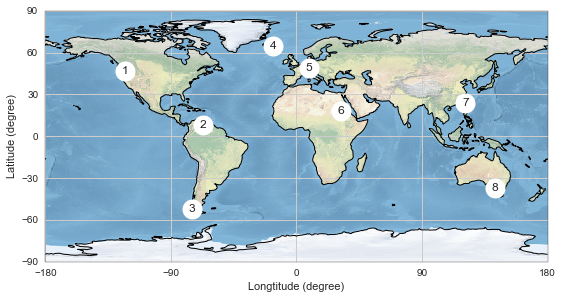

In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import string

plt.figure(figsize=(9, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# make the map global rather than have it zoom in to
# the extents of any plotted data
ax.set_global()
ax.stock_img()
ax.coastlines()
ax.set_xticks([-180, -90, 0, 90, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())

for position, num in zip([[47,-123],[8,-67], [-52,-75],[65, -17],[49,9],[18,32],[24,121],[-37,142]], arange(1,9)):
    print(position)
    plt.plot(position[1], position[0], marker='o', markersize=20, color='white')
    plt.text(position[1], position[0], num, verticalalignment='center', horizontalalignment='center')
    
plt_configure(xlabel='Longtitude (degree)', ylabel='Latitude (degree)')

In [ ]:
fig = plt.figure(figsize=(4.2,2.4))
ax1 = fig.add_subplot(1,2,1) 
plot_2d_prob_density(X, Y, kde_Z, ax=ax1,
                     xlabel='x'+speed_unit_text, ylabel='y'+speed_unit_text, colorbar=False)
ax1.grid(False)
ax2 = fig.add_subplot(1,2,2) 
plot_2d_prob_density(X, Y, pdf_Z, ax=ax2,
                     xlabel='x'+speed_unit_text, ylabel='y'+speed_unit_text, colorbar=False)
ax2.grid(False)
ax2.get_yaxis().set_visible(False)

In [ ]:
%%time
true_R_square_mean_set=[]
for year_length in [5,10]:
    start_year, end_year = df_all_years.index.year[0], 2015-year_length+1
    df_standard = df_all_years[str(2015-year_length+1):str(2015)]
    true_R_square_set = []
    for sub_start_year in arange(start_year, end_year+1):
        sub_end_year = sub_start_year+year_length-1
        df_previous =  df_all_years[str(sub_start_year):str(sub_end_year)]
        density_collection=Parallel(n_jobs=-1)(delayed(direction_compare)(None, df_standard, angle, incre, True, df_previous) 
                                            for angle in arange(0, 360, incre))  
        true_R_square_set.append(true_R_square(density_collection))
    true_R_square_set=pd.DataFrame(true_R_square_set, index=arange(start_year, end_year+1))
    year_lim = end_year-year_length-5, end_year-year_length
    true_R_square_mean = true_R_square_set.query('index >= @year_lim[0] & index <= @year_lim[1]').mean()
    true_R_square_mean['year_lim']=year_lim
    true_R_square_mean_set.append(true_R_square_mean)
    plot(true_R_square_set, label=year_length)
plt_configure(legend=True)
display(pd.DataFrame(true_R_square_mean_set).set_index('year_lim'))